# Chapter 6. Learning Best Practices for Model Evaluation and Hyperparameter Tuning

연속형 target $y$와 두개의 연속형 변수 $x_1, x_2$로 구성된 데이터에 대해 아래와 같은 모형을 생각해볼 수 있다.
$$y = w_0 + w_1 x_1 + w_2 x_2$$

혹은 모형의 복잡도를 조금 높여서 아래와 같은 모형을 생각해볼 수도 있다.
$$y = w_0 + w_1 x_1 + w_2 x_2 + (w_3 x_1 + w_4 x_2)^k$$

여기서 $k$가 커질수록 모형의 복잡도는 높아지며, variance가 커지며, overfitting할 가능성도 커지게 된다.     
이런 변수는 우리가 데이터를 통해 학습하려는 weight($w_0, w_1, \dots$)과는 별개로 모형의 형태를 결정하는 변수로서 weight과는 다른 의미를 갖는다. 이처럼 모형을 결정하는 변수를 tunning-parameter 혹은 hyper-parameter라 하며, training data의 크기 혹은 regularization parameter, kernel parameter등 모형에 따라 다양한 변수들이 포함될 수 있다.

hyper-parameter의 값에 따라 모형의 성능이 좋아지거나 혹은 나빠질 수 있는데,    
좋은 hyper-parameter 값을 선택하기 위해서는 hyper-parameter값에 따른 모형의 성능을 평가할 수 있는 기준이 있어야 할 것이다.

이번 Chapter에서는 hyper-parameter를 잘 선택하는 방법과 모형을 평가할 수 있는 기준에 대해 알아본다.

### 데이터 준비

이번에는 UCI machine learning repository에 올라와 있는 Brest Cancer 데이터를 이용할 것이다.   
데이터는 569명의 환자의 30개 특성과 이 환자가 악성(malignant)인지 혹은 양성(benigh)인지를 나타내는 타겟 변수로 구성되어 있다.

> - pandas.**read_csv**를 이용한 데이터 불러오기

In [3]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
                 ,header=None)
df.head()

0  1      2      3       4       5        6        7       8   \
0    842302  M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001   
1    842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869   
2  84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974   
3  84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414   
4  84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980   

        9    ...        22     23      24      25      26      27      28  \
0  0.14710   ...     25.38  17.33  184.60  2019.0  0.1622  0.6656  0.7119   
1  0.07017   ...     24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416   
2  0.12790   ...     23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504   
3  0.10520   ...     14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869   
4  0.10430   ...     22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000   

       29      30       31  
0  0.2654  0.4601  0.11890  
1  0.1860  0.2750  0.08902  
2  0.2430  0.3613  0.08758  
3  0.2575  0.6638  0.17300  
4  0.1625  0.2364  0.07678  

[5 rows x 32 columns]

In [4]:
len(df)

569

> - 1번째 컬럼을 $\mathbf{y}$로 사용, 2번째부터 끝까지 컬럼을 $\mathbf{X}$로 사용
> - sklearn.preprocessing.**LabelEncoder**를 이용해 y의 label(M: 악성, B: 양성)을 각각 1과 0으로 변환

In [5]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)


le.transform(['M', 'B'])

array([1, 0], dtype=int64)

> - sklearn.cross_validation.**train_test_split**을 이용해 training set과 test set을 8:2로 나눔

In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

### Pipeline 

데이터를 모형에 사용하기 전에 데이터를 가공하는 과정이 선행되고    
이후 모형에 가공된 데이터를 투입하여 모형을 학습시킨다.     
sklearn에서는 이런 데이터 처리/학습 과정을 패키징 할 수 있도록 Pipeline이라는 Class를 제공한다.

아래 예제 코드에서는      
변수들의 단위를 맞추는 작업(Standardize)    
변수의 차원을 낮추는 작업(PCA)     
로지스틱 회귀 모형까지 하나의 Pipeline에 담고 있다.

> - sklearn.pipeline.**Pipeline**에 두개의 transformer(StandardScaler, PCA)와 estimator(LogisticRegression)을 설정
> - 앞서 train_test_split을 이용해 나눈 training set 데이터를 이용해 모형 학습
> - test set 데이터를 이용해 모형의 정확도를 확인         
※ 정확도(accuracy)는 전체 예측 중 '정'예측의 비율      
$$ACC = \frac{TP + TN}{FP + FN + TP + TN} = 1 - ERR$$

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler())
                    , ('pca', PCA(n_components=2))
                    , ('clf', LogisticRegression(random_state=1))])

pipe_lr.fit(X_train, y_train)                    
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


<img  src="./_images/06_pipeline.PNG"/>

### 데이터를 나눠 모형 검증

예를들어 1번부터 100번까지 100문항의 수학 문제가 있고,     
이 문제로 공부한 후 얼마나 잘 학습 했는지를 평가 하기 위해     
다시 이 문제들을 풀어본다면?   
이미 풀어봤던 문제들 이므로 당연히 잘 풀수밖에 없다. 즉 평가를 위해서는 풀어보지 않았던 문제를 이용해야만 한다.

> [방법1]    
그렇다면 우리에게는 100문제밖에 없으므로       
90문제는 공부하는데 사용하고      
나머지 10문제는 평가에 사용하는 방법도 가능하다.

그런데 만약 뒷쪽 문제들은 지나치게 어려운 문제들이었다면       
평가가 정확하지 않을 것이다. 즉 문제들을 나누는 경우에 따라 평가 결과가 달라지게 된다.

> [방법2]     
좀 더 나은 아이디어는 문제들은 나누는 방법을 여러가지로 달리하여     
각 경우(1~10번가지 문제가 평가로 쓰이거나, 11~20번까지 문제가 평가로 쓰이거나, ... 여러가지 경우) 마다의 평가 점수를 계산하고 이들의 평균 값을 평가점수로 사용한다면 보다 합리적인 결과를 얻을 수 있을 것이다.

> [방법3]     
각 문제에 난이도를 표시하는 '난이도 상', '난이도 하'가 표시되어 있다면        
공부에 사용하는 데이터와 평가에 사용하는 데이터의 난이도 분포가 유사하도록 문제들을 나눠     
'방법2'와 같이 여러 경우로 나눠 평가한다면 더더욱 좋을 것이다.



[방법1]을 **holdout**, [방법2]를 **K겹 교차 검증(K-fold cross validation)**,         
[방법3]을 **층화 교차 검증(Stratified cross-validation)**이라 한다.     
sklearn에 구현된 층화 교차 검증 패키지를 이용해 아래와 같이 모형을 학습/평가 해 볼 수 있다.

> sklearn.cross_validation.**StratifiedKFold**를 이용한 층화된 교차 검증(stratified cross-validation)
> - 각 fold의 $\mathbf{y}$ label 비율이 256:153으로 일정하게 유지됨을 알 수 있다.

In [8]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train
                       , n_folds=10
                       , random_state=0)
scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956
CV accuracy: 0.950 +/- 0.029


> - 위 코드에서 numpy.bincount()는 ndarray에 있는 0의 건수와 1의 건수를 각각 반환

In [9]:
print(np.bincount(np.array([1, 0, 0, 0])))

[3 1]


In [10]:
print(np.bincount(y_train))

[285 170]


In [11]:
285 / (285 + 170)

0.6263736263736264

In [12]:
256 / (256 + 153)

0.6259168704156479

> 10건만으로 테스트 해 보면 아래와 같이 0과 1의 비율이 3:2로 일정하게 유지됨을 확인 할 수 있다.

In [13]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold
print(y_train[0:10])
kfold = StratifiedKFold(y=y_train[0:10]
                       , n_folds=2
                       , random_state=0)
scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    

[1 1 0 0 0 0 0 1 1 0]
Fold: 1, Class dist.: [3 2], Acc: 1.000
Fold: 2, Class dist.: [3 2], Acc: 1.000
CV accuracy: 1.000 +/- 0.000


> - 앞서 sklearn.cross_validation.**StratifiedKFold**를 이용해 했던 일을      
sklearn.cross_validation.**cross_val_score**을 이용해서도 할 수 있으며      
이것을 이용할 경우 multi-core를 활용할 수 있다.(n_jobs: 코어 수)

In [14]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=pipe_lr
                         , X=X_train
                         , y=y_train
                         , cv=10
                         , n_jobs=1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


### 학습 곡선(learning curves)

모형이 지나치게 복잡한지(high variance) 혹은 단순한지(high bias) 또는 데이터가 더 필요한 상황인지 등을 판단하기 위해 training set data의 크기를 늘려가면서 'training set data에 대한 정예측율(Accuracy)'와 'test set data에 대한 정예측율(Accuracy)'를 그래프로 그려볼 수 있다.     
이렇게 training set size에 따른 (training set / test set에 대한) Accuracy의 변화 그래프를 **학습곡선(Learning curve)**이라 한다.

학습곡선의 형태에 따라 모형의 적합도를 판단할 수 있는데      
아래 첫번째 그림과 같이 training set / test set 모두에 좋지 않은 accuracy가 나오는 경우 모형이 너무 단순한 경우라고 할 수 있다. 이에 대한 대응으로는 변수를 늘린다거나, regularization을 약하게 하는 등을 생각해볼 수 있다.

아래 두번째 그림은 training set에는 accuracy가 높으나 training data의 양이 증가해도 test set에 대한 accuracy가 크게 좋아지지 않는 경우이다. 이는 overfitting이 심한 상황으로서 데이터를 더 투입해 보거나, regularization을 강하게 하여 모형을 좀더 단순하게 하는 방안을 사용해볼 수 있다.

아래 세번째 그림은 최상의 경우로서 데이터 량이 어느정도 이상이 되면 training set에 대한 accuracy와 test set에 대한 accuracy가 만족스러운 값으로 수렴하는 형태이다.

<img  src="./_images/06_learning_curve.PNG"/>

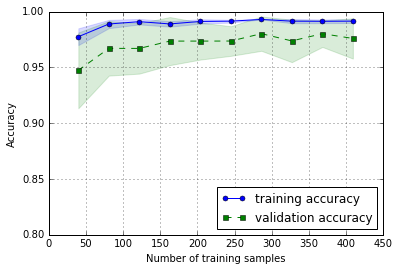

In [16]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
%matplotlib inline
# %matplotlib auto

pipe_lr = Pipeline([('scl', StandardScaler())
                    , ('clf', LogisticRegression(penalty='l2', random_state=0))])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr
                                                        , X=X_train
                                                        , y=y_train
                                                        , train_sizes=np.linspace(0.1, 1.0, 10)
                                                        , cv=10
                                                        , n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
color='blue', marker='o',
markersize=5,
label='training accuracy')
plt.fill_between(train_sizes,
train_mean + train_std,
train_mean - train_std,
alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
color='green', linestyle='--',
marker='s', markersize=5,
label='validation accuracy')
plt.fill_between(train_sizes,
test_mean + test_std,
test_mean - test_std,
alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

### 검정 곡선(validation curves)

traning data의 크기 뿐만 아니라 regularization의 정도를 결정하는 변수 등 model parameter(hyper-parameter) 값을 적절한 값으로 결정해야만 한다. 이를 위해 여러 후보 값을 이용해 training set / test set 데이터에 대한 accuracy를 측정해 보고 test set에 가장 좋은 성능을 보이는 값을 선택한다.

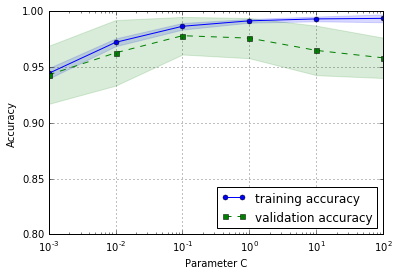

In [18]:
from sklearn.learning_curve import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='clf__C',
    param_range=param_range,
    cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
    color='blue', marker='o',
    markersize=5,
    label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
plt.plot(param_range, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=5,
    label='validation accuracy')
plt.fill_between(param_range,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

### 평가 기준(Accuracy, Precision, Recall, F1-score)

환자가 암에 걸렸는지 진단하는 상황이라 해 보자.      
암을 진단하는 것은 쉬운 일이 아니라 할 때              
진단이 맞고 틀리는 경우는 아래 4가지 상황이 가능하다.     
1. 암에 걸린 환자를 암에 걸렸다고 하는 경우
2. 암에 걸린 환자를 암에 안 걸렸다고 하는 경우
3. 암에 안 걸린 환자를 암에 안 걸렸다고 하는 경우
4. 암에 안 걸린 환자를 암에 안 걸렸다고 하는 경우

실제 암에 걸린 상황을 Positive라 하고, 암에 걸리지 않은 상황을 Negative라 하면    
위 상황을 아래와 같이 표현할 수 있다.
1. True Positive(TP)
2. False Positive(FP)
3. True Negative(TN)
4. False Negative(FN)

실제 값(Actual/True Class)과 예측값(Predicted class)를 아래와 같은 **confusion matrix**로 표현할 수 있다.

<img  src="./_images/06_conf.PNG"/>

예를들어 조금만 암의 징후가 보여도 암이라 예측하는 의사 a와       
정말 암이라는 확신이 있을 때에만 암이라 진단하는 의사 b가    
100명의 환자에 대해     
발병율 10%인 암에 대해 아래와 같은 예측을 했다고 하자.   
(실제로 100명중 10명이 암에 걸렸다고 가정)

즉 의사a는 20명(TP+FP)을 암이라 진단 했는데, 그들 중 8명(TP)만 정말 암에 걸린 환자이고     
반변 의사b는 10명(TP+FP)을 암이라 진단 했는데, 그들 중 4명(TP)만 정말 암에 걸린 환자이다.

In [83]:
a_tp = 8; a_fn = 2
a_fp = 12; a_tn = 78

b_tp = 4; b_fn = 6
b_fp = 6; b_tn = 84

두 의사 중 누가 더 좋은 결정을 한 것인가?    
이에 대한 판단은 그 기준에 따라 달라지게 된다.

우선 암이든 아니든 잘 예측한 비율을 따져보면    
의사a는 암에 걸린 10명 중 8명(TP)에 대해, 암에 걸리지 않은 90명 중 78명(TN)에게 맞는(True) 진단을 내렸다. 이는 전체 환자중 86%이다.

반면 의사b는 암에 걸린 10명 중 4명(TP)에 대해, 암에 걸리지 않은 90명 중 84명(TN)에게 맞는(True) 진단을 내렸다. 이는 전체 환자 중 88%이다.

이렇게 전체 예측 중 True 예측의 비율을 정확도(Accuracy)라 하며 아래와 같이 계산한다.
$$ACC = \frac{TP + TN}{FP + FN + TP + TN}$$

In [89]:
def get_acc(tp, fn, fp, tn):
    return (tp + tn) / (fp + fn + tp + tn)

print('의사a의 Accuracy: ', get_acc(a_tp, a_fn, a_fp, a_tn))
print('의사b의 Accuracy: ', get_acc(b_tp, b_fn, b_fp, b_tn))

의사a의 Accuracy:  0.86
의사b의 Accuracy:  0.88


그렇다면 의사b의 진단이 더 나은 것인가?    
이번에는 기준을 바꿔서 '암이라고 진단한 환자 중 정말 암에 걸린 사람의 비율'을 보면   
의사a는 20명을 암이라 진단 했고 이들 중 8명이 진짜 암 환자이므로 40%이고    
의사b는 10명을 암이라 진단 했고 이들 중 4명이 진짜 암 환자이므로 그 비율은 40%이다.

이렇게 Positive로 예측한 것들 중 True Positive의 비율을 정밀도(Precision)이라 하며 아래와 같이 계산한다.
$$PRE = \frac{TP}{TP + FP}$$

In [95]:
def get_pre(tp, fn, fp, tn):
    return tp / (tp + fp)
a_pre = get_pre(a_tp, a_fn, a_fp, a_tn)
b_pre = get_pre(b_tp, b_fn, b_fp, b_tn)
print('의사a의 Precision: ', a_pre)
print('의사b의 Precision: ', b_pre)

의사a의 Precision:  0.4
의사b의 Precision:  0.4


또 다른 기준으로 '정말 암에 걸린 사람 중, 암이라 진단 받은 사람의 비율'을 보면    
의사a는 암에 걸린 10명 중 8명을 암이라 진단해서 그 비율은 80%이고   
의사b는 암에 걸린 10명 중 4명을 암이라 진단해서 그 비율은 40%이다.

이렇게 True Positive 중 Positive라고 잘 예측한 비율을 재현율(Recall)이라 하며 아래와 같이 계산한다.(Recall을 Sensitivity, True-positive rate, Probability of detection이라고도 함) 
$$REC = \frac{TP}{FN + TP}$$

In [100]:
def get_rec(tp, fn, fp, tn):
    return (tp) / (fn + tp)
a_rec = get_rec(a_tp, a_fn, a_fp, a_tn)
b_rec = get_rec(b_tp, b_fn, b_fp, b_tn)
print('의사a의 Recall: ', a_rec)
print('의사b의 Recall: ', b_rec)

의사a의 Recall:  0.8
의사b의 Recall:  0.4


사실 대충 그냥 다 암이라고 진단하면 Recall이 높아지게 되고        
아주 정말 암 같아야 암이라고 진단하면 Precision이 높아지게 된다.

즉 판단의 기준(근거가 몇%이상이어야 Positive라 판단하는가)에 따라 하나의 평가 기준으로는 우열을 가리기 어려운 상황이 생기게 된다.

두 지표(Recall, Precision)을 절충한 지표로 **F1-score**가 있으며 아래와 같이 계산한다.
$$F1 = 2 ~ \frac{PRE \times REC}{PRE + REC}$$

In [99]:
def get_f1(pre, rec):
    return 2 * (pre * rec) / (pre + rec)
print('의사a의 F1-score: ', get_f1(a_pre, a_rec))
print('의사b의 F1-score: ', get_f1(b_pre, b_rec))

의사a의 F1-score:  0.5333333333333333
의사b의 F1-score:  0.4000000000000001


참고로 가설검정에서 False Positive(귀무가설을 잘못 기각)를 **Type 1 error**라고,    
False Negative(귀무가설을 잘못 기각하지 못함)를 **Type 2 error**라 한다.

그럼 의사a가 더 좋은 의사인가?    
모르겠습니다...

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl', StandardScaler()), ('clf', SVC(random_state=1))])

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


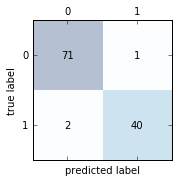

In [21]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
        s=confmat[i, j],
        va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

### ROC Curve

두 의사의 예와 같이 암이라는 증거가 충분한 경우(예를들어 90%이상 확신하는 경우) 암이라 진단할 수도 있고 암 이라는 증거가 조금만 보여도(예를들어 50%이상 확신하는 경우) 암이라 진단할 수도 있다.

즉 판단의 기준(decision threshold)에 따라 암 환자를 암이라고 예측하는 비율이 달라지게 된다. 이렇게 decision threshold에 따른 True Positive의 비율(암 환자를 암이라 진단하는 비율)과 False Positive의 비율(암 환자를 정상이라 진단하는 비율)을 그래프로 표현해 볼 수 있는데, 이를 **ROC Curve**(Receiver Operating Characteristic Curve혹은 Relative Operating Characteristic Curve)라 한다.

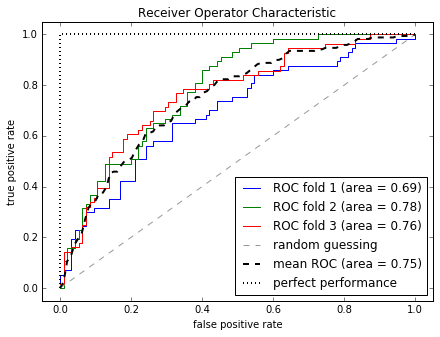

In [22]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(y_train,
    n_folds=3,
    random_state=1)
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
        tpr,
        lw=1,
        label='ROC fold %d (area = %0.2f)'
        % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

곡선 아래의 면적을 **AUC**(Area Under the Curve)라 하며 이 값이 클 수록 좋은 모형이라 할 수 있다.(이에 대한 반론도 있으며 DeltaP등의 다른 평가 지표를 사용하기도 한다.)

In [23]:
pipe_svc = pipe_svc.fit(X_train2, y_train)
y_pred2 = pipe_svc.predict(X_test[:, [4, 14]])
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(
    y_true=y_test, y_score=y_pred2))

print('Accuracy: %.3f' % accuracy_score(
    y_true=y_test, y_pred=y_pred2))


ROC AUC: 0.671
Accuracy: 0.728
